In [109]:
import json
import numpy as np
import pandas as pd
import calendar
import matplotlib.pyplot as plt

with open("transaction-data-adhoc-analysis.json","r") as f:
    dataset = json.load(f)
df = pd.DataFrame(dataset)
df_clean_transactional_items = pd.DataFrame(columns=["Items","Amount","Individual Price","Sale Value","Month"])

In [110]:
df.head()

,address,birthdate,mail,name,sex,username,transaction_items,transaction_value,transaction_date
0,USNS Wagner\nFPO AE 00917,1926/03/11,watsonbrenda@gmail.com,Jennifer Campbell,F,veronicawells,"Exotic Extras,Beef Chicharon,(x4)",5196,2022/01/12
1,USCGC Benson\nFPO AP 48794,2016/07/08,moorelisa@gmail.com,Melissa Kim,F,cgilbert,"Exotic Extras,Beef Chicharon,(x3);HealthyKid 3...",12056,2022/01/12
2,USCGC Benson\nFPO AP 48794,2016/07/08,moorelisa@gmail.com,Melissa Kim,F,cgilbert,"HealthyKid 3+,Gummy Vitamins,(x3);HealthyKid 3...",5500,2022/01/08
3,USCGC Benson\nFPO AP 48794,2016/07/08,moorelisa@gmail.com,Melissa Kim,F,cgilbert,"HealthyKid 3+,Yummy Vegetables,(x1)",500,2022/01/10
4,"33911 Hansen Loaf\nWest Sandra, ND 54188",1949/09/27,michael78@yahoo.com,Kristen Cooper,F,qhernandez,"Candy City,Orange Beans,(x3);Candy City,Gummy ...",2697,2022/01/24


In [111]:
#Separating each Item
transaction_items = list(df["transaction_items"])
transaction_items_only = [transaction_items[i].split(";") for i in range(len(transaction_items))]
df_items = pd.DataFrame({"Items":transaction_items_only})
df_clean_transactional_items["Items"] = df_items.explode("Items")

In [112]:
#Get the Item Only (removing brand and amount)
items = list(df_clean_transactional_items["Items"])
items_only = [items[i][items[i].find(",")+1:-5] for i in range(len(items))]
df_clean_transactional_items["Items"] = items_only
df_clean_transactional_items["Items"].mask(df_clean_transactional_items["Items"] == "Nutrional Milk","Nutritional Milk",inplace = True)

In [113]:
#Getting Amount Bought
amount = [int(items[i][items[i].find("(") + 2:-1]) for i in range(len(items))]
df_clean_transactional_items["Amount"] = amount

In [114]:
#Getting Individual Price
transaction_value = df["transaction_value"]
df_clean_transactional_items["Total Transaction Value"] = transaction_value

chicharon_price = df_clean_transactional_items.loc[:,"Items"] == "Beef Chicharon"
milk_price = df_clean_transactional_items.loc[:,"Items"] == "Nutritional Milk"
beans_price = df_clean_transactional_items.loc[:,"Items"] == "Orange Beans"
vitamins_price = df_clean_transactional_items.loc[:,"Items"] == "Gummy Vitamins"
vegetables_price = df_clean_transactional_items.loc[:,"Items"] == "Yummy Vegetables"
worms_price = df_clean_transactional_items.loc[:,"Items"] == "Gummy Worms"
kimchiseaweed_price = df_clean_transactional_items.loc[:,"Items"] == "Kimchi and Seaweed"

prices = {"Beef Chicharon":list(df_clean_transactional_items.loc[chicharon_price,:].min(numeric_only = True))[1],
          "Nutritional Milk":list(df_clean_transactional_items.loc[milk_price,:].min(numeric_only = True))[1],
          "Orange Beans":list(df_clean_transactional_items.loc[beans_price,:].min(numeric_only = True))[1],
          "Gummy Vitamins":list(df_clean_transactional_items.loc[vitamins_price,:].min(numeric_only = True))[1],
          "Yummy Vegetables":list(df_clean_transactional_items.loc[vegetables_price,:].min(numeric_only = True))[1],
          "Gummy Worms":list(df_clean_transactional_items.loc[worms_price,:].min(numeric_only = True))[1],
          "Kimchi and Seaweed":list(df_clean_transactional_items.loc[kimchiseaweed_price,:].min(numeric_only = True))[1]}

def price_list(x):
    return prices[x]

df_clean_transactional_items["Individual Price"] = df_clean_transactional_items["Items"].apply(price_list)

In [115]:
#Getting Sale Value
df_clean_transactional_items["Sale Value"] = df_clean_transactional_items["Individual Price"]*df_clean_transactional_items["Amount"]

In [116]:
#Getting Month
month_number = df[["transaction_date"]].squeeze()
month_name = pd.to_datetime(df["transaction_date"]).dt.month_name()
df_clean_transactional_items["Month"] = month_name

In [117]:
#CLEAN DATA TABLE
df_clean_transactional_items[["Items","Amount","Individual Price","Sale Value","Month"]]

,Items,Amount,Individual Price,Sale Value,Month
0,Beef Chicharon,4,1299,5196,January
1,Beef Chicharon,3,1299,3897,January
1,Nutritional Milk,4,1990,7960,January
1,Orange Beans,1,199,199,January
2,Gummy Vitamins,3,1500,4500,January
...,...,...,...,...,...
83034,Nutritional Milk,2,1990,3980,June
83034,Gummy Worms,2,150,300,June
83035,Nutritional Milk,1,1990,1990,June
83035,Gummy Worms,3,150,450,June


In [118]:
#Getting the Amount of Each Item Sold per Month
from calendar import month_name
amount_per_month = df_clean_transactional_items.groupby(["Items","Month"],as_index = False)["Amount"].sum().pivot("Items","Month").fillna(0)
category_month = pd.CategoricalDtype(categories = list(month_name),ordered=True)
amount_per_month.columns = [amount_per_month.columns.get_level_values(0),amount_per_month.columns.get_level_values(1).astype(category_month)]
amount_per_month = amount_per_month.sort_index(axis = 1,level = [1,0])

#BREAKDOWN MINIMUM REQUIREMENT 1: AMOUNT OF EACH ITEM SOLD PER MONTH
amount_per_month

Amount                                     
Month              January February  March  April    May   June
Items                                                          
Beef Chicharon        9665    10001   9816   9890  10028   9902
Gummy Vitamins        9681     9980  10145   9842   9948   9980
Gummy Worms           9559     9996   9986  10043   9801   9934
Kimchi and Seaweed    9676     9949   9967   9921   9773  10104
Nutritional Milk      9727     9691   9876   9786   9881   9767
Orange Beans          9774    10037   9611   9914   9964  10106
Yummy Vegetables      9959    10256   9896   9861   9735   9722

In [119]:
#Getting the Sale Value of Each Item per Month
sv_per_month = df_clean_transactional_items.groupby(["Items","Month"],as_index = False)["Sale Value"].sum().pivot("Items","Month").fillna(0)
sv_per_month.columns = [sv_per_month.columns.get_level_values(0),sv_per_month.columns.get_level_values(1).astype(category_month)]
sv_per_month = sv_per_month.sort_index(axis = 1,level = [1,0])

#BREAKDOWN MINIMUM REQUIREMENT 2: SALE VALUE OF EACH ITEM PER MONTH
sv_per_month

Sale Value                                          \
Month                 January  February     March     April       May   
Items                                                                   
Beef Chicharon       12554835  12991299  12750984  12847110  13026372   
Gummy Vitamins       14521500  14970000  15217500  14763000  14922000   
Gummy Worms           1433850   1499400   1497900   1506450   1470150   
Kimchi and Seaweed    7731124   7949251   7963633   7926879   7808627   
Nutritional Milk     19356730  19285090  19653240  19474140  19663190   
Orange Beans          1945026   1997363   1912589   1972886   1982836   
Yummy Vegetables      4979500   5128000   4948000   4930500   4867500   

                              
Month                   June  
Items                         
Beef Chicharon      12862698  
Gummy Vitamins      14970000  
Gummy Worms          1490100  
Kimchi and Seaweed   8073096  
Nutritional Milk    19436330  
Orange Beans         2011094  
Yummy Vegetables     4861000

In [120]:
#Table for Customer Transactions
df_clean_transactional_items["Customer Name"] = df["name"]

monthly_customer_transactions = df_clean_transactional_items.groupby("Customer Name")["Month"].apply(" ".join).reset_index()
monthly_customer_transactions["January"] = monthly_customer_transactions["Month"].str.contains("January")
monthly_customer_transactions["February"] = monthly_customer_transactions["Month"].str.contains("February")
monthly_customer_transactions["March"] = monthly_customer_transactions["Month"].str.contains("March")
monthly_customer_transactions["April"] = monthly_customer_transactions["Month"].str.contains("April")
monthly_customer_transactions["May"] = monthly_customer_transactions["Month"].str.contains("May")
monthly_customer_transactions["June"] = monthly_customer_transactions["Month"].str.contains("June")

monthly_customer_transactions[["Customer Name","January","February","March","April","May","June"]]

,Customer Name,January,February,March,April,May,June
0,Aaron Beasley,False,False,False,True,True,True
1,Aaron Brewer,True,True,True,True,False,True
2,Aaron Brown,False,False,True,True,True,True
3,Aaron Coffey,True,True,True,True,True,False
4,Aaron Davis,True,True,False,True,True,True
...,...,...,...,...,...,...,...
8482,Zachary Valentine,True,True,True,True,True,True
8483,Zachary Ware,True,True,True,True,True,True
8484,Zachary Williams,True,True,True,True,False,False
8485,Zachary Wilson,False,False,False,True,True,True


In [121]:
#Repeaters Data
repeat_february = [(monthly_customer_transactions["January"].eq(True)) &
            (monthly_customer_transactions["January"].eq(monthly_customer_transactions["February"])),
            monthly_customer_transactions["January"].eq(False)]
repeat_march = [(monthly_customer_transactions["February"].eq(True)) &
            (monthly_customer_transactions["February"].eq(monthly_customer_transactions["March"])),
            monthly_customer_transactions["February"].eq(False)]
repeat_april = [(monthly_customer_transactions["March"].eq(True)) &
            (monthly_customer_transactions["March"].eq(monthly_customer_transactions["April"])),
            monthly_customer_transactions["March"].eq(False)]
repeat_may = [(monthly_customer_transactions["April"].eq(True)) &
            (monthly_customer_transactions["April"].eq(monthly_customer_transactions["May"])),
            monthly_customer_transactions["April"].eq(False)]
repeat_june = [(monthly_customer_transactions["May"].eq(True)) &
            (monthly_customer_transactions["May"].eq(monthly_customer_transactions["June"])),
            monthly_customer_transactions["May"].eq(False)]

conditions = ["Repeater", "Non-repeater"]
monthly_customer_transactions["January Repeater?"] = "Does Not Count"
monthly_customer_transactions["February Repeater?"] = np.select(repeat_february, conditions, default = "Non-repeater")
monthly_customer_transactions["March Repeater?"] = np.select(repeat_march, conditions, default = "Non-repeater")
monthly_customer_transactions["April Repeater?"] = np.select(repeat_april, conditions, default = "Non-repeater")
monthly_customer_transactions["May Repeater?"] = np.select(repeat_may, conditions, default = "Non-repeater")
monthly_customer_transactions["June Repeater?"] = np.select(repeat_june, conditions, default = "Non-repeater")

In [122]:
#Counting # of Repeaters
repnum_feb = monthly_customer_transactions.loc[:,"February Repeater?"] == "Repeater"
repnum_mar = monthly_customer_transactions.loc[:,"March Repeater?"] == "Repeater"
repnum_apr = monthly_customer_transactions.loc[:,"April Repeater?"] == "Repeater"
repnum_may = monthly_customer_transactions.loc[:,"May Repeater?"] == "Repeater"
repnum_jun = monthly_customer_transactions.loc[:,"June Repeater?"] == "Repeater"

repeater_count = {"January":0,
             "February":list(monthly_customer_transactions.loc[repnum_feb,:].count())[0],
             "March":list(monthly_customer_transactions.loc[repnum_mar,:].count())[0],
             "April":list(monthly_customer_transactions.loc[repnum_apr,:].count())[0],
             "May":list(monthly_customer_transactions.loc[repnum_may,:].count())[0],
             "June":list(monthly_customer_transactions.loc[repnum_jun,:].count())[0]}

In [123]:
#Inactive Data
inactive_february = [(monthly_customer_transactions["January"].eq(True)) &
            (monthly_customer_transactions["February"].eq(False)),
            monthly_customer_transactions["January"].eq(False)]
inactive_march = [(monthly_customer_transactions["March"].eq(False)) &
            (monthly_customer_transactions[["January","February"]].any(axis="columns")),
            monthly_customer_transactions["March"].eq(True)]
inactive_april = [(monthly_customer_transactions["April"].eq(False)) &
            (monthly_customer_transactions[["January","February","March"]].any(axis="columns")),
            monthly_customer_transactions["April"].eq(True)]
inactive_may = [(monthly_customer_transactions["May"].eq(False)) &
            (monthly_customer_transactions[["January","February","March","April"]].any(axis="columns")),
            monthly_customer_transactions["May"].eq(True)]
inactive_june = [(monthly_customer_transactions["June"].eq(False)) &
            (monthly_customer_transactions[["January","February","March","April","May"]].any(axis="columns")),
            monthly_customer_transactions["June"].eq(True)]

conditions2 = ["Inactive", ""]
monthly_customer_transactions["January Active Status?"] = "Does Not Count"
monthly_customer_transactions["February Active Status?"] = np.select(inactive_february, conditions2, default = "")
monthly_customer_transactions["March Active Status?"] = np.select(inactive_march, conditions2, default = "")
monthly_customer_transactions["April Active Status?"] = np.select(inactive_april, conditions2, default = "")
monthly_customer_transactions["May Active Status?"] = np.select(inactive_may, conditions2, default = "")
monthly_customer_transactions["June Active Status?"] = np.select(inactive_june, conditions2, default = "")

In [124]:
#Counting # of Inactive Customers
innum_feb = monthly_customer_transactions.loc[:,"February Active Status?"] == "Inactive"
innum_mar = monthly_customer_transactions.loc[:,"March Active Status?"] == "Inactive"
innum_apr = monthly_customer_transactions.loc[:,"April Active Status?"] == "Inactive"
innum_may = monthly_customer_transactions.loc[:,"May Active Status?"] == "Inactive"
innum_jun = monthly_customer_transactions.loc[:,"June Active Status?"] == "Inactive"

inactive_count = {"January":0,
             "February":list(monthly_customer_transactions.loc[innum_feb,:].count())[0],
             "March":list(monthly_customer_transactions.loc[innum_mar,:].count())[0],
             "April":list(monthly_customer_transactions.loc[innum_apr,:].count())[0],
             "May":list(monthly_customer_transactions.loc[innum_may,:].count())[0],
             "June":list(monthly_customer_transactions.loc[innum_jun,:].count())[0]}

In [125]:
#Engaged Data
engaged_january = [monthly_customer_transactions["January"].eq(True),
                   monthly_customer_transactions["January"].eq(False)]
engaged_february = [(monthly_customer_transactions[["January","February"]].all(axis="columns")),
                     monthly_customer_transactions["January"].eq(False)]
engaged_march = [(monthly_customer_transactions[["January","February","March"]].all(axis="columns")),
                 monthly_customer_transactions["January"].eq(False)]
engaged_april = [(monthly_customer_transactions[["January","February","March","April"]].all(axis="columns")),
                 monthly_customer_transactions["January"].eq(False)]
engaged_may = [(monthly_customer_transactions[["January","February","March","April","May"]].all(axis="columns")),
               monthly_customer_transactions["January"].eq(False)]
engaged_june = [(monthly_customer_transactions[["January","February","March","April","May","June"]].all(axis="columns")),
                monthly_customer_transactions["January"].eq(False)]

conditions3 = ["Engaged", ""]
monthly_customer_transactions["January Engagement?"] = np.select(engaged_january, conditions3, default = "")
monthly_customer_transactions["February Engagement?"] = np.select(engaged_february, conditions3, default = "")
monthly_customer_transactions["March Engagement?"] = np.select(engaged_march, conditions3, default = "")
monthly_customer_transactions["April Engagement?"] = np.select(engaged_april, conditions3, default = "")
monthly_customer_transactions["May Engagement?"] = np.select(engaged_may, conditions3, default = "")
monthly_customer_transactions["June Engagement?"] = np.select(engaged_june, conditions3, default = "")

In [126]:
#Counting # of Engaged Customers
ennum_jan = monthly_customer_transactions.loc[:,"January Engagement?"] == "Engaged"
ennum_feb = monthly_customer_transactions.loc[:,"February Engagement?"] == "Engaged"
ennum_mar = monthly_customer_transactions.loc[:,"March Engagement?"] == "Engaged"
ennum_apr = monthly_customer_transactions.loc[:,"April Engagement?"] == "Engaged"
ennum_may = monthly_customer_transactions.loc[:,"May Engagement?"] == "Engaged"
ennum_jun = monthly_customer_transactions.loc[:,"June Engagement?"] == "Engaged"

engaged_count = {"January":list(monthly_customer_transactions.loc[ennum_jan,:].count())[0],
             "February":list(monthly_customer_transactions.loc[ennum_feb,:].count())[0],
             "March":list(monthly_customer_transactions.loc[ennum_mar,:].count())[0],
             "April":list(monthly_customer_transactions.loc[ennum_apr,:].count())[0],
             "May":list(monthly_customer_transactions.loc[ennum_may,:].count())[0],
             "June":list(monthly_customer_transactions.loc[ennum_jun,:].count())[0]}

In [127]:
#Almost Engaged Customer Data (Active in the past months)
almost_engaged_february = [(monthly_customer_transactions["January"].eq(True)),
                     monthly_customer_transactions["January"].eq(False)]
almost_engaged_march = [(monthly_customer_transactions[["January","February"]].all(axis="columns")),
                 monthly_customer_transactions["January"].eq(False)]
almost_engaged_april = [(monthly_customer_transactions[["January","February","March"]].all(axis="columns")),
                 monthly_customer_transactions["January"].eq(False)]
almost_engaged_may = [(monthly_customer_transactions[["January","February","March","April"]].all(axis="columns")),
               monthly_customer_transactions["January"].eq(False)]
almost_engaged_june = [(monthly_customer_transactions[["January","February","March","April","May"]].all(axis="columns")),
               monthly_customer_transactions["January"].eq(False)]

conditions4 = ["Almost Engaged", ""]
monthly_customer_transactions["January Almost Engaged?"] = "Does not Count"
monthly_customer_transactions["February Almost Engaged?"] = np.select(almost_engaged_february, conditions4, default = "")
monthly_customer_transactions["March Almost Engaged?"] = np.select(almost_engaged_march, conditions4, default = "")
monthly_customer_transactions["April Almost Engaged?"] = np.select(almost_engaged_april, conditions4, default = "")
monthly_customer_transactions["May Almost Engaged?"] = np.select(almost_engaged_may, conditions4, default = "")
monthly_customer_transactions["June Almost Engaged?"] = np.select(almost_engaged_june, conditions4, default = "")

In [128]:
#Counting # of Almost Engaged Customers
alennum_feb = monthly_customer_transactions.loc[:,"February Almost Engaged?"] == "Almost Engaged"
alennum_mar = monthly_customer_transactions.loc[:,"March Almost Engaged?"] == "Almost Engaged"
alennum_apr = monthly_customer_transactions.loc[:,"April Almost Engaged?"] == "Almost Engaged"
alennum_may = monthly_customer_transactions.loc[:,"May Almost Engaged?"] == "Almost Engaged"
alennum_jun = monthly_customer_transactions.loc[:,"June Almost Engaged?"] == "Almost Engaged"

almost_engaged_count = {"January":0,
             "February":list(monthly_customer_transactions.loc[alennum_feb,:].count())[0],
             "March":list(monthly_customer_transactions.loc[alennum_mar,:].count())[0],
             "April":list(monthly_customer_transactions.loc[alennum_apr,:].count())[0],
             "May":list(monthly_customer_transactions.loc[alennum_may,:].count())[0],
             "June":list(monthly_customer_transactions.loc[alennum_jun,:].count())[0]}

In [129]:
#First Time Buyer Data
first_january = [(monthly_customer_transactions["January"].eq(True)),
                     monthly_customer_transactions["January"].eq(False)]
first_february = [(monthly_customer_transactions["January"].eq(False))&
                  (monthly_customer_transactions["February"].eq(True)),
                  monthly_customer_transactions["February"].eq(False)]
first_march = [((monthly_customer_transactions[["January","February"]]==0).all(axis="columns"))&
                  (monthly_customer_transactions["March"].eq(True)),
                  monthly_customer_transactions["March"].eq(False)]
first_april = [((monthly_customer_transactions[["January","February","March"]]==0).all(axis="columns"))&
                  (monthly_customer_transactions["April"].eq(True)),
                  monthly_customer_transactions["April"].eq(False)]
first_may = [((monthly_customer_transactions[["January","February","March","April"]]==0).all(axis="columns"))&
                  (monthly_customer_transactions["May"].eq(True)),
                  monthly_customer_transactions["May"].eq(False)]
first_june = [((monthly_customer_transactions[["January","February","March","April","May"]]==0).all(axis="columns"))&
                  (monthly_customer_transactions["June"].eq(True)),
                  monthly_customer_transactions["June"].eq(False)]

conditions5 = ["First Time", ""]
monthly_customer_transactions["January First Time?"] = np.select(first_january, conditions5, default = "")
monthly_customer_transactions["February First Time?"] = np.select(first_february, conditions5, default = "")
monthly_customer_transactions["March First Time?"] = np.select(first_march, conditions5, default = "")
monthly_customer_transactions["April First Time?"] = np.select(first_april, conditions5, default = "")
monthly_customer_transactions["May First Time?"] = np.select(first_may, conditions5, default = "")
monthly_customer_transactions["June First Time?"] = np.select(first_june, conditions5, default = "")

In [130]:
#Counting # of First Time Buyers
ftbnum_jan = monthly_customer_transactions.loc[:,"January First Time?"] == "First Time"
ftbnum_feb = monthly_customer_transactions.loc[:,"February First Time?"] == "First Time"
ftbnum_mar = monthly_customer_transactions.loc[:,"March First Time?"] == "First Time"
ftbnum_apr = monthly_customer_transactions.loc[:,"April First Time?"] == "First Time"
ftbnum_may = monthly_customer_transactions.loc[:,"May First Time?"] == "First Time"
ftbnum_jun = monthly_customer_transactions.loc[:,"June First Time?"] == "First Time"

first_time_count = {"January":list(monthly_customer_transactions.loc[ftbnum_jan,:].count())[0],
             "February":list(monthly_customer_transactions.loc[ftbnum_feb,:].count())[0],
             "March":list(monthly_customer_transactions.loc[ftbnum_mar,:].count())[0],
             "April":list(monthly_customer_transactions.loc[ftbnum_apr,:].count())[0],
             "May":list(monthly_customer_transactions.loc[ftbnum_may,:].count())[0],
             "June":list(monthly_customer_transactions.loc[ftbnum_jun,:].count())[0]}

In [131]:
#Making the Table for Monthly Customer Transactions
january = [repeater_count["January"],inactive_count["January"],engaged_count["January"],almost_engaged_count["January"],first_time_count["January"]]
february = [repeater_count["February"],inactive_count["February"],engaged_count["February"],almost_engaged_count["February"],first_time_count["February"]]
march = [repeater_count["March"],inactive_count["March"],engaged_count["March"],almost_engaged_count["March"],first_time_count["March"]]
april = [repeater_count["April"],inactive_count["April"],engaged_count["April"],almost_engaged_count["April"],first_time_count["April"]]
may = [repeater_count["May"],inactive_count["May"],engaged_count["May"],almost_engaged_count["May"],first_time_count["May"]]
june = [repeater_count["June"],inactive_count["June"],engaged_count["June"],almost_engaged_count["June"],first_time_count["June"]]
first_column = ["Repeaters","Inactive","Engaged","Almost Engaged","First Time Buyers"]

df_customer_table = pd.DataFrame({"Customer Type":first_column,"January":january,"February":february,"March":march,"April":april,"May":may,"June":june})
df_customer_table.set_index("Customer Type",inplace=True)

#CUSTOMER TRANSACTION AND ACTIVITY DATA
df_customer_table

,January,February,March,April,May,June
Customer Type,,,,,,
Repeaters,0,5172,5216,5154,5110,5193
Inactive,0,1416,1747,1909,1917,1835
Engaged,6588,5172,4126,3289,2667,2190
Almost Engaged,0,6588,5172,4126,3289,2667
First Time Buyers,6588,1459,322,96,20,2


In [132]:
#Extra Visuals: Graphs and Charts
#Data Assignment
month_data = ["January","February","March","April","May","June"]

january_data = np.array(list(amount_per_month.iloc[:,0]))
february_data = np.array(list(amount_per_month.iloc[:,1]))
march_data = np.array(list(amount_per_month.iloc[:,2]))
april_data = np.array(list(amount_per_month.iloc[:,3]))
may_data = np.array(list(amount_per_month.iloc[:,4]))
june_data = np.array(list(amount_per_month.iloc[:,5]))

items_data = ["Beef Chicharon","Gummy Vitamins","Gummy Worms","Kimchi and Seaweed","Nutritional Milk","Orange Beans","Yummy Vegetables"]

chicharon_data = np.array(list(amount_per_month.iloc[0,:]))
vitamins_data = np.array(list(amount_per_month.iloc[1,:]))
worms_data = np.array(list(amount_per_month.iloc[2,:]))
kimchiseaweed_data = np.array(list(amount_per_month.iloc[3,:]))
milk_data = np.array(list(amount_per_month.iloc[4,:]))
beans_data = np.array(list(amount_per_month.iloc[5,:]))
vegetables_data = np.array(list(amount_per_month.iloc[6,:]))

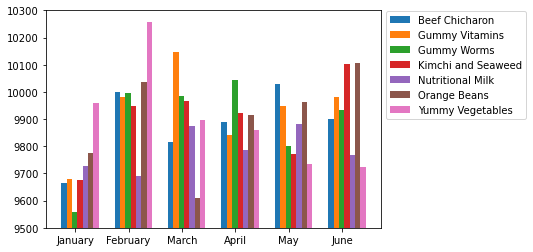

In [133]:
#Bar Graph for Amount of item sold
plt.bar(np.arange(6),chicharon_data,width=0.10,label="Beef Chicharon")
plt.bar(np.arange(6) + 0.10,vitamins_data,width=0.10,label="Gummy Vitamins")
plt.bar(np.arange(6) + 2*0.10,worms_data,width=0.10,label="Gummy Worms")
plt.bar(np.arange(6) + 3*0.10,kimchiseaweed_data,width=0.10,label="Kimchi and Seaweed")
plt.bar(np.arange(6) + 4*0.10,milk_data,width=0.10,label="Nutritional Milk")
plt.bar(np.arange(6) + 5*0.10,beans_data,width=0.10,label="Orange Beans")
plt.bar(np.arange(6) + 6*0.10,vegetables_data,width=0.10,label="Yummy Vegetables")

plt.xticks(np.arange(6) + 0.21, month_data)
plt.ylim(9500,10300)
plt.legend(loc="center left",bbox_to_anchor=(1,0.75))

plt.show()

In [134]:
#Data Assignment
items_data = ["Beef Chicharon","Gummy Vitamins","Gummy Worms","Kimchi and Seaweed","Nutritional Milk","Orange Beans","Yummy Vegetables"]

chicharon_data2 = (list(sv_per_month.iloc[0,:]))
vitamins_data2 = (list(sv_per_month.iloc[1,:]))
worms_data2 = (list(sv_per_month.iloc[2,:]))
kimchiseaweed_data2 = (list(sv_per_month.iloc[3,:]))
milk_data2 = (list(sv_per_month.iloc[4,:]))
beans_data2 = (list(sv_per_month.iloc[5,:]))
vegetables_data2 = (list(sv_per_month.iloc[6,:]))

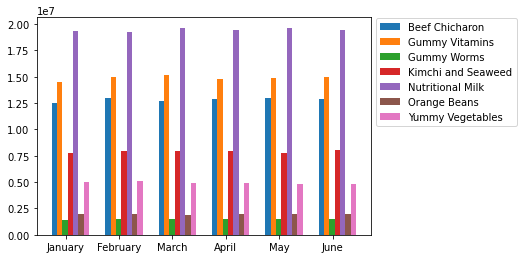

In [135]:
#Bar Graph for Sale Value of Each Item Per Month
plt.bar(np.arange(6),chicharon_data2,width=0.10,label="Beef Chicharon")
plt.bar(np.arange(6) + 0.10,vitamins_data2,width=0.10,label="Gummy Vitamins")
plt.bar(np.arange(6) + 2*0.10,worms_data2,width=0.10,label="Gummy Worms")
plt.bar(np.arange(6) + 3*0.10,kimchiseaweed_data2,width=0.10,label="Kimchi and Seaweed")
plt.bar(np.arange(6) + 4*0.10,milk_data2,width=0.10,label="Nutritional Milk")
plt.bar(np.arange(6) + 5*0.10,beans_data2,width=0.10,label="Orange Beans")
plt.bar(np.arange(6) + 6*0.10,vegetables_data2,width=0.10,label="Yummy Vegetables")

plt.xticks(np.arange(6) + 0.21, month_data)
plt.legend(loc="center left",bbox_to_anchor=(1,0.75))

plt.show()

In [136]:
#Data Assignment
repeater_data = list(df_customer_table.iloc[0,:])
inactive_data = list(df_customer_table.iloc[1,:])
engaged_data = list(df_customer_table.iloc[2,:])
almost_engaged_data = list(df_customer_table.iloc[3,:])
first_data = list(df_customer_table.iloc[4,:])

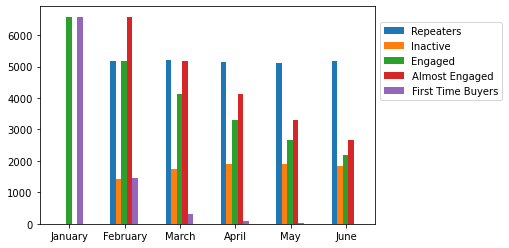

In [137]:
#Bar Graph for Customer Transaction and Activity
plt.bar(np.arange(6),repeater_data,width=0.10,label="Repeaters")
plt.bar(np.arange(6) + 0.10,inactive_data,width=0.10,label="Inactive")
plt.bar(np.arange(6) + 2*0.10,engaged_data,width=0.10,label="Engaged")
plt.bar(np.arange(6) + 3*0.10,almost_engaged_data,width=0.10,label="Almost Engaged")
plt.bar(np.arange(6) + 4*0.10,first_data,width=0.10,label="First Time Buyers")

plt.xticks(np.arange(6) + 0.21, month_data)
plt.legend(loc="center left",bbox_to_anchor=(1,0.75))

plt.show()